<a href="https://colab.research.google.com/github/vijayshankarrealdeal/GoogleColab/blob/main/Retino2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d dola1507108/diabetic-retinopathy-organized

In [ ]:
!unzip '/content/diabetic-retinopathy-organized.zip' -d '/content/'

In [97]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout

In [5]:
datagen = ImageDataGenerator(  
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest' 
    )

In [156]:
train_data = datagen.flow_from_directory(
    '/content/Diabetic Retinopathy Classified/Train',
    target_size = (224,224),
    class_mode = 'categorical',
    batch_size = 64,
    shuffle = True,
)

Found 31619 images belonging to 5 classes.


In [175]:
validation_datagen = ImageDataGenerator(
    rescale=1. / 255,
)
validation_data = validation_datagen.flow_from_directory(
    '/content/Diabetic Retinopathy Classified/Validation',
    target_size = (224,224),
    class_mode = 'categorical',
    shuffle = True,
)

Found 1755 images belonging to 6 classes.


In [176]:
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False,
                                            input_tensor = Input(shape = (224, 224, 3)))

In [177]:
len(base_model.layers)

19

In [178]:
for layers in base_model.layers:
  layers.trainable = True

In [179]:
head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = Dense(units = 1025, activation='relu')(head_model)
head_model = Dropout(rate = 0.2)(head_model)
head_model = Dense(units = 1025, activation='relu')(head_model)
head_model = Dropout(rate = 0.2)(head_model)
head_model = Dense(5, activation='softmax')(head_model)

In [180]:
network = Model(inputs = base_model.input, outputs = head_model)

In [181]:
network.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

In [182]:
network.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [184]:
class Callbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('accuracy') > 0.75):
      self.model.stop_training = True
call = Callbacks()

In [185]:
history = network.fit(train_data,
                    epochs=50,
                    batch_size=64,
                    callbacks=call,
                    #validation_data = validation_data,
                    steps_per_epoch=len(train_data) /64,
                    )

Epoch 1/50
7/7 [==============================] - 60s 2s/step - loss: 3.5808 - accuracy: 0.6543
Epoch 2/50
7/7 [==============================] - 18s 2s/step - loss: 0.9429 - accuracy: 0.7461
Epoch 3/50
7/7 [==============================] - 18s 2s/step - loss: 0.9308 - accuracy: 0.7266
Epoch 4/50
7/7 [==============================] - 19s 2s/step - loss: 0.8888 - accuracy: 0.7363
Epoch 5/50
7/7 [==============================] - 18s 2s/step - loss: 0.7795 - accuracy: 0.7656


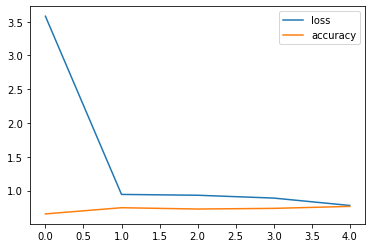

In [186]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['accuracy'],label='accuracy')
plt.legend()
plt.show()

In [187]:
test_datagen = ImageDataGenerator(
    rescale=1. / 255,
)
test_data = test_datagen.flow_from_directory(
    '/content/Diabetic Retinopathy Classified/Test',
    target_size = (224,224),
)

Found 1754 images belonging to 5 classes.


In [188]:
predict = network.predict(test_data)

In [189]:
final_res = np.argmax(predict,axis = 1)

In [190]:
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

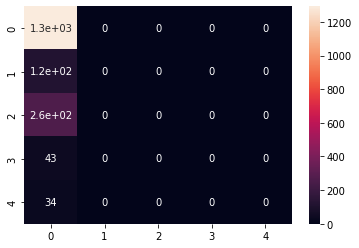

In [191]:
cm = confusion_matrix(test_data.classes,final_res)
sns.heatmap(cm,annot=True)

In [192]:
accuracy_score(test_data.classes,final_res)*100

73.66020524515393